In this notebook, we'll be implementing the example of MPC and MHE from the doMPC documentation

# MPC

In [107]:
import numpy as np

# Add do_mpc to path. This is not necessary if it was installed via pip.
import sys
sys.path.append('../../')

# Import do_mpc package:
import do_mpc

# Allows us to vertically concatenate symbolic expressions
from casadi import *

import matplotlib.pyplot as plt

# Model

In [108]:
# Setting up the model
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)


# Variables can also be vectors:
phi = model.set_variable(var_type='_x', var_name='phi', shape=(3,1))
dphi = model.set_variable(var_type='_x', var_name='dphi', shape=(3,1)) #x4,x5,x6

# Two inputs for the desired (set) motor position:
phi_m_set = model.set_variable(var_type='_u', var_name='phi_m_set', shape=(2,1))

# Two additional states for the true motor position:
phi_m = model.set_variable(var_type='_x', var_name='phi_m', shape=(2,1))


# Model Measurements (MHE)

# State measurements
phi_meas = model.set_meas('phi_1_meas', phi, meas_noise=True) # We have measurement noise for the states

# Input measurements
phi_m_set_meas = model.set_meas('phi_m_set_meas', phi_m_set, meas_noise=False) # But we know exactly the u's


# As shown in the table above, we can use Long names or short names for the variable type.
Theta_1 = model.set_variable('parameter', 'Theta_1') # Interial masses
Theta_2 = model.set_variable('parameter', 'Theta_2')
Theta_3 = model.set_variable('parameter', 'Theta_3')

c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
d = np.array([6.78,  8.01,  8.82])*1e-5


# Seting the RHS
model.set_rhs('phi', dphi)

dphi_next = vertcat(
    -c[0]/Theta_1*(phi[0]-phi_m[0])-c[1]/Theta_1*(phi[0]-phi[1])-d[0]/Theta_1*dphi[0],
    -c[1]/Theta_2*(phi[1]-phi[0])-c[2]/Theta_2*(phi[1]-phi[2])-d[1]/Theta_2*dphi[1],
    -c[2]/Theta_3*(phi[2]-phi[1])-c[3]/Theta_3*(phi[2]-phi_m[1])-d[2]/Theta_3*dphi[2],
)

model.set_rhs('dphi', dphi_next, process_noise = False)

tau = 1e-2
model.set_rhs('phi_m', 1/tau*(phi_m_set - phi_m))

model.setup()

# Estimator

In [109]:
mhe = do_mpc.estimator.MHE(model) 

In [110]:
# We'll be trying to estimate Theta 1 AND the states (we try to estiamte the remaining states by default)
mhe = do_mpc.estimator.MHE(model, ['Theta_1']) 
setup_mhe = {
    't_step': 0.1,
    'n_horizon': 10,
    'store_full_solution': True,
    'meas_from_data': True # Data will be taken from the MHE data object. 
}
mhe.set_param(**setup_mhe)

# Setting the objective function
P_v = np.diag(np.array([1,1,1])) # This is the measurement noise. Recall that we are measuing 3 states only so there are only 3 inputs (measurement noise)
P_x = np.eye(8) # This is the weighting matrix of the states (8 states)
P_p = 10*np.eye(1) # Wegithing matrix of the parametere (1 parameter we will estimaTe)
#P_w is not required
 
mhe.set_default_objective(P_x, P_v, P_p)
#mhe.set_default_objective(P_x, P_p = P_p)


# If we are trying to estimate fixed parameters, we have the supply the model with the estimate of the remaining parameters
p_template_mhe = mhe.get_p_template()
def p_fun_mhe(t_now):
    p_template_mhe['Theta_2'] = 2.25e-4
    p_template_mhe['Theta_3'] = 2.25e-4
    return p_template_mhe

mhe.set_p_fun(p_fun_mhe)

# Setting points on what the us can be 
mhe.bounds['lower','_u', 'phi_m_set'] = -2*np.pi
mhe.bounds['upper','_u', 'phi_m_set'] = 2*np.pi

mhe.bounds['lower','_p_est', 'Theta_1'] = 1e-5
mhe.bounds['upper','_p_est', 'Theta_1'] = 1e-3

mhe.setup()

In [111]:
y0 = np.array([[ 2.00379704],
       [-1.8519687 ],
       [-3.50803999],
       [-0.26840994],
       [ 0.67048955]])
mhe.p_est0 = 1e-4
mhe.set_initial_guess()
x0 = mhe.make_step(y0)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1180
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      119

Total number of variables............................:      403
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       21
                     variables with only upper bounds:        0
Total number of equality constraints.................:      370
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

# Controller

In [112]:
# Setting up the controller
mpc = do_mpc.controller.MPC(model)
setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 1,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

# Objective and constraints
mterm = phi[0]**2 + phi[1]**2 + phi[2]**2
lterm = phi[0]**2 + phi[1]**2 + phi[2]**2

mpc.set_objective(mterm=mterm, lterm=lterm)

# Lower bounds on states:
mpc.bounds['lower','_x', 'phi'] = -2*np.pi
# Upper bounds on states
mpc.bounds['upper','_x', 'phi'] = 2*np.pi

# Lower bounds on inputs:
mpc.bounds['lower','_u', 'phi_m_set'] = -2*np.pi
# Lower bounds on inputs:
mpc.bounds['upper','_u', 'phi_m_set'] = 2*np.pi

#Scaling
mpc.scaling['_x', 'phi'] = 2

# We're not entirely surte about the parameters of the inertial masses
inertia_mass_1 = 2.25*1e-4*np.array([1., 0.9, 1.1])
inertia_mass_2 = 2.25*1e-4*np.array([1., 0.9, 1.1])
inertia_mass_3 = 2.25*1e-4*np.array([1.])

mpc.set_uncertainty_values(
    Theta_1 = inertia_mass_1,
    Theta_2 = inertia_mass_2,
    Theta_3 = inertia_mass_3
)
mpc.setup()

# Simulator

In [113]:
# setting up the simulator
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = 0.1)

# We can have the Theta values chaneg randmly - but for now they will be fixed in time
p_template = simulator.get_p_template()
def p_fun(t_now):
    p_template['Theta_1'] = 2.25e-4
    p_template['Theta_2'] = 2.25e-4
    p_template['Theta_3'] = 2.25e-4
    return p_template
simulator.set_p_fun(p_fun)
simulator.setup()

# Simulation loop

In [114]:
y0

array([[ 2.00379704],
       [-1.8519687 ],
       [-3.50803999],
       [-0.26840994],
       [ 0.67048955]])

In [115]:
def random_u(u0):
    # Hold the current value with 80% chance or switch to new random value.
    u_next = (0.5-np.random.rand(2,1))*np.pi # New candidate value.
    switch = np.random.rand() >= 0.8 # switching? 0 or 1.
    u0 = (1-switch)*u0 + switch*u_next # Old or new value.
    return u0

simulator.reset_history()
mhe.reset_history()

# Simulation loop
x0 = np.pi*np.array([1, 1, -1.5, 1, -1, 1, 0, 0]).reshape(-1,1)
x0_mhe = x0*(1+0.5*np.random.randn(8,1))

simulator.x0 = x0
mhe.x0_mhe = x0_mhe
mhe.p_est0 = 1e-4
mhe.set_initial_guess()

u0 = np.zeros((2,1))

for i in range(50):
    u0 = random_u(u0) # Control input
    v0 = 0.1*np.random.randn(model.n_v,1) # measurement noise
    y0 = simulator.make_step(u0, v0=v0)
    x0 = mhe.make_step(y0) # MHE estimation step
    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1180
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      119

Total number of variables............................:      403
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       21
                     variables with only upper bounds:        0
Total number of equality constraints.................:      370
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

           S  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |        0 (       0)        0 (       0)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  10.00ms ( 10.00ms)  10.17ms ( 10.17ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1180
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      119

Total number of variables............................:      403
                     variables with only lower bounds:        0
        

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1180
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      119

Total number of variables............................:      403
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       21
                     variables with only upper bounds:        0
Total number of equality constraints.................:      370
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

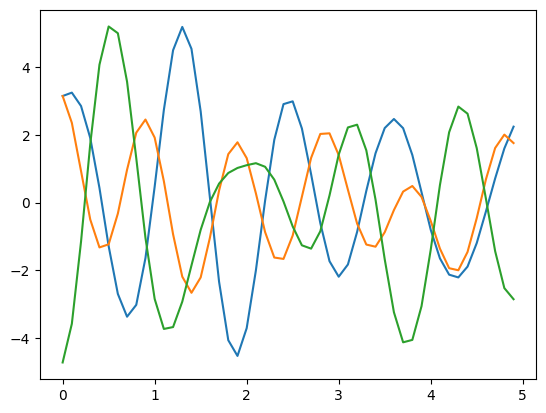

In [116]:
angles = simulator.data['_x'][:,0:3]
time = simulator.data['_time']
plt.plot(time,angles)

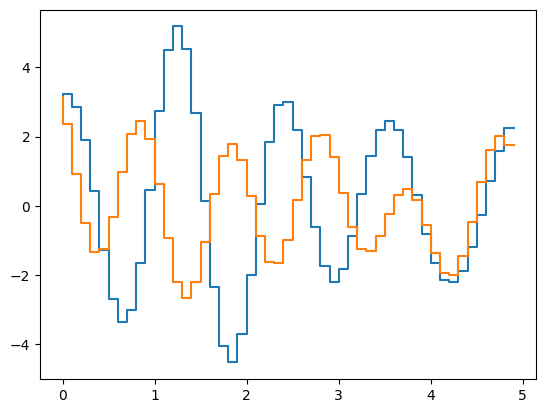

In [117]:
c_input = simulator.data['_x'][:,0:2]
time = simulator.data['_time']
plt.step(time,c_input)

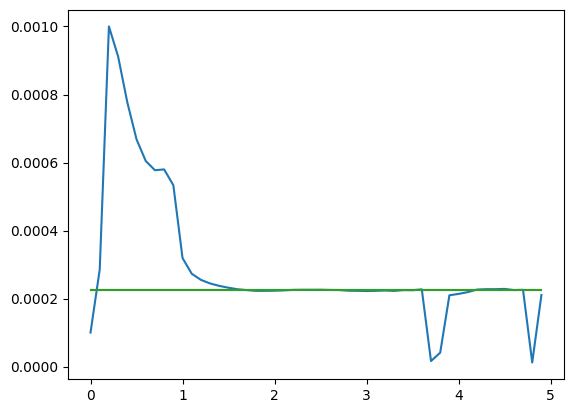

In [120]:
est_theta1 = mhe.data['_p']
plt.plot(time,est_theta1)

In [119]:
mpc.data['_p']

array([], shape=(0, 3), dtype=float64)